# I used ordinary least squares(OLS) and common polynimial regression to predict data. What you see below is what I got. 
I know the codes are kind of duplicates, I will simplize it after.
<br>p.s. If you just want to see the result, please see the "Result" part

In [80]:
import pandas as pd
import numpy as np 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [103]:
footfall = pd.read_excel("Footfall_DLR_Daily.xlsx")
date = pd.to_datetime("2022-1-1")
date1 = pd.to_datetime("2021-12-31")
date2 = pd.to_datetime("2022-12-31")
footfalls = footfall.loc[pd.to_datetime(footfall["UTC Datetime"])>date1]
footfall_2021 = footfall.loc[pd.to_datetime(footfall["UTC Datetime"])<date]
footfall_2022 = footfalls.loc[pd.to_datetime(footfalls["UTC Datetime"])<date2] 
footfall_2023 = footfall.loc[pd.to_datetime(footfall["UTC Datetime"])>date2]
footfall_2021 = pd.DataFrame.drop_duplicates(footfall_2021).reset_index()
footfall_2022 = pd.DataFrame.drop_duplicates(footfall_2022).reset_index()
footfall_2023 = pd.DataFrame.drop_duplicates(footfall_2023).reset_index()

In [82]:
class cla:
    def __init__(self,footfall,s):
        self.footfall = footfall
        self.s = s
        self.area = footfall.loc[footfall["Sensor Number"]==s]
    def street(self,name):
        self.street = self.area.loc[self.area["countlineName"]==name]
        return self.street
class regression:
    def __init__(self,footfall):
        self.footfall = footfall
        self.pred = np.array([])
    def poly_regression(self,deg):
        self.footfalls = self.footfall.loc[self.footfall["Pedestrian"]!=0]
        poly = PolynomialFeatures(degree=deg,include_bias=False)
        x = np.arange(0,len(self.footfall))
        x1 = np.arange(0,len(self.footfalls))
        poly_features = poly.fit_transform(x1.reshape(-1, 1))
        poly_reg_model = LinearRegression()
        model = poly_reg_model.fit(poly_features, self.footfalls["Pedestrian"])
        poly_feature = poly.fit_transform(np.arange(0,len(self.footfall)).reshape(-1,1))
        pred = poly_reg_model.predict(poly_feature)
        self.pred=pred
        plt.scatter(x1,self.footfalls["Pedestrian"]),
        plt.plot(x,pred,color="r"),plt.title("poly_regression"),
        plt.xlabel("days"),plt.ylabel("footfall")
        plt.show()
        plt.figure(figsize=(9,6))
    
    def corr_Prediction(self):
        Prediction = {"real ":self.footfall["Pedestrian"][:-31],
                     "pred ":self.pred[:-31]}
        Prediction = pd.DataFrame(Prediction)
        return plt.subplots(figsize=(6,4)),sns.heatmap(Prediction.corr(), annot = True)


# The graph you see below is a result of predicting missing data by polynominal regression

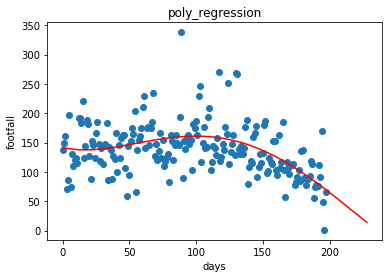

((<Figure size 432x288 with 2 Axes>, <AxesSubplot:>), <AxesSubplot:>)

<Figure size 648x432 with 0 Axes>

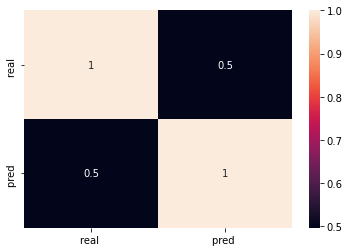

In [83]:
a = cla(footfall_2021,"S2")
data = a.street("S2_StGeorgesUpperSt_dlr001")
d = regression(data.loc[data["direction"]=="out"])
d.poly_regression(4)
d.corr_Prediction()

the correlation graph showing the grade of prediciton from May to Nov for S2_StGeorgesUpperSt in 2021

# What you see below is a result of predicting missing data by OLS
* For OLS, I seperated data into two parts
* From the date 5/17 to 9/30 would be train data
* From the date 10/1 to 11/30 would be test data

### For the OLS, it is difficult to predict good outcomes using single data. Therefore there are two stratgies to predict the data. 
* predict S2 georgeSt pedertrian in 2021 by using S2 georgeSt data in 2022 as the factor
* predict S2 georgeSt pedertrian in 2021 by using area S1 in 2021 and S3 in 2021 as the factors

In [84]:
a = cla(footfall_2021,"S2")
b = cla(footfall_2022,"S2")
data1 = a.area
data2 = b.area

train_2021=data1.loc[pd.to_datetime(data1["UTC Datetime"])<pd.to_datetime("2021-10-1")]
train_2022=data2.loc[pd.to_datetime(data2["UTC Datetime"])<pd.to_datetime("2022-10-1")]
train_2022=train_2022.loc[pd.to_datetime(train_2022["UTC Datetime"])>pd.to_datetime("2022-5-16")]

test_2021 =data1.loc[pd.to_datetime(data1["UTC Datetime"])>=pd.to_datetime("2021-10-1")]
test_2022 = data2.loc[pd.to_datetime(data2["UTC Datetime"])>=pd.to_datetime("2022-10-1")]
test_2022 = test_2022.loc[pd.to_datetime(test_2022["UTC Datetime"])<pd.to_datetime("2022-12-1")]
test_2021 = test_2021.loc[pd.to_datetime(test_2021["UTC Datetime"])<pd.to_datetime("2021-12-1")]

train_2022 = pd.DataFrame.drop_duplicates(train_2022)
test_2022 = pd.DataFrame.drop_duplicates(test_2022)

### predict S2 georgeSt pedertrian in 2021 by using 2022 data as the factor

In [85]:
import statsmodels.api as sm
constant = sm.add_constant(train_2022["Pedestrian"])
model = sm.OLS(list(train_2021["Pedestrian"]),constant)
result = model.fit()
new_constant=sm.add_constant(test_2022["Pedestrian"])
pred = result.predict(new_constant)

/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


October
real     365350
predicted 403569.41608563793
November
real     327762
predicted 398137.96002087265


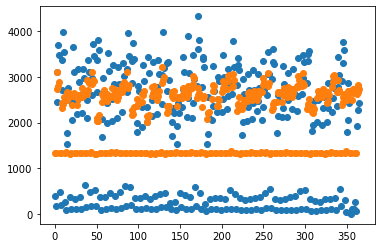

In [86]:
x = np.arange(len(test_2021))
plt.scatter(x,test_2021["Pedestrian"],label="real")
plt.scatter(x,pred.values,label="predicted")
print("October")
print("real    ",sum(test_2021.loc[pd.to_datetime(test_2021["UTC Datetime"])<pd.to_datetime("2021-11-1")]["Pedestrian"]))
print("predicted",sum(pred.values[:186]))
print("November")
print("real    ",sum(test_2021.loc[pd.to_datetime(test_2021["UTC Datetime"])>=pd.to_datetime("2021-11-1")]["Pedestrian"]))
print("predicted",sum(pred.values[186:]))

what you see above, is a graph showing the real pedestrians(blue) and predicted pedestrians(orange) for test data(10/1 to 11/30 in S2 area) in 2021 when use 2022 data as factor

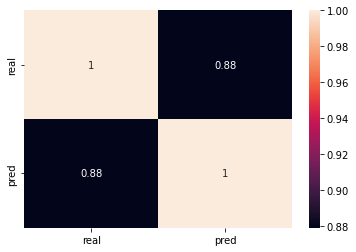

In [87]:
Prediction = {"real":test_2021["Pedestrian"],
              "pred":pred.values
             }
Prediction = pd.DataFrame(Prediction)
sns.heatmap(Prediction.corr(), annot = True)
reg = LinearRegression().fit(constant,list(train_2021["Pedestrian"]))

the correlation graph showing the grade of prediciton test data in 2021

In [88]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     344.7
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           1.65e-64
Time:                        19:13:45   Log-Likelihood:                -6922.6
No. Observations:                 822   AIC:                         1.385e+04
Df Residuals:                     820   BIC:                         1.386e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1298.6247     52.901     24.548      0.000    1194.788    1402.462
Pedestrian     0.4946      0.027     18.567      0.000       0.442       0.547
==============================================================================
Omnibus:                       94.732   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.148
Skew:                           0.661   Prob(JB):                     1.77e-17
Kurtosis:                       2.288   Cond. No.                     2.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
a = cla(footfall_2021,"S2")
data1 = a.area
b = cla(footfall_2021,"S3")
data2 = b.area
c = cla(footfall_2021,"S1")
data3 = c.area

train_S2 = data1.loc[pd.to_datetime(data1["UTC Datetime"])<pd.to_datetime("2021-10-1")]
train_S3 = data2.loc[pd.to_datetime(data2["UTC Datetime"])<pd.to_datetime("2021-10-1")]
train_S1 = data3.loc[pd.to_datetime(data3["UTC Datetime"])<pd.to_datetime("2021-10-1")]
train = {"S1":np.array(train_S1["Pedestrian"]),
           "S3":np.array(train_S3["Pedestrian"])}
train = pd.DataFrame(train)

test_S2 = data1.loc[pd.to_datetime(data1["UTC Datetime"])>pd.to_datetime("2021-10-1")]
test_S1 = data2.loc[pd.to_datetime(data2["UTC Datetime"])>pd.to_datetime("2021-10-1")]
test_S3 = data3.loc[pd.to_datetime(data3["UTC Datetime"])>pd.to_datetime("2021-10-1")]
test_S2 = test_S2.loc[pd.to_datetime(test_S2["UTC Datetime"])<pd.to_datetime("2021-12-1")]
test_S1 = test_S1.loc[pd.to_datetime(test_S1["UTC Datetime"])<pd.to_datetime("2021-12-1")]
test_S3 = test_S3.loc[pd.to_datetime(test_S3["UTC Datetime"])<pd.to_datetime("2021-12-1")]
test = {"S1":np.array(test_S1["Pedestrian"]),
           "S3":np.array(test_S3["Pedestrian"])}
test = pd.DataFrame(test)

In [105]:
len(train)

822

### predict S2 georgeSt pedertrian in 2021 by using area S1 and S3 of 2021 as the factors

In [91]:
constant = sm.add_constant(train)
model = sm.OLS(list(train_S2["Pedestrian"]),constant)
result = model.fit()
new_constant=sm.add_constant(test)
pred = result.predict(new_constant)

/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


October
real     352050
predicted 388114.14685549465
November
real     316960
predicted 356217.040603497


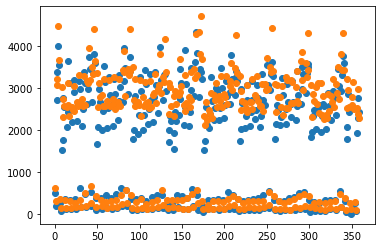

In [106]:
x = np.arange(len(test_S2))
plt.scatter(x,test_S2["Pedestrian"])
plt.scatter(x,pred)
print("October")
print("real    ",sum(test_S2.loc[pd.to_datetime(test_S2["UTC Datetime"])<pd.to_datetime("2021-11-1")]["Pedestrian"]))
print("predicted",sum(pred.values[:186]))
print("November")
print("real    ",sum(test_S2.loc[pd.to_datetime(test_S2["UTC Datetime"])>pd.to_datetime("2021-11-1")]["Pedestrian"]))
print("predicted",sum(pred.values[186:]))

what you see above, is a graph showing the real pedestrians(blue) and predicted pedestrians(orange) for test data(10/1 to 11/30) in 2021 when use S1 and S2 areas as factors

<AxesSubplot:>

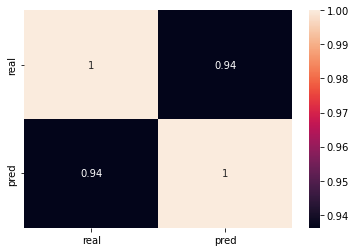

In [94]:
Prediction = {"real":test_S2["Pedestrian"],
              "pred":pred.values
             }
Prediction = pd.DataFrame(Prediction)
sns.heatmap(Prediction.corr(), annot = True)

the correlation graph showing the grade of prediciton test data in 2021

In [14]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     419.8
Date:                Mon, 03 Jul 2023   Prob (F-statistic):          3.17e-126
Time:                        17:18:31   Log-Likelihood:                -6776.8
No. Observations:                 822   AIC:                         1.356e+04
Df Residuals:                     819   BIC:                         1.357e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8115     80.674     -0.097      0.923    -166.164     150.541
S1             0.7540      0.046     16.374      0.000       0.664       0.844
S3             1.0499      0.046     22.623      0.000       0.959       1.141
==============================================================================
Omnibus:                       40.367   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.924
Skew:                          -0.152   Prob(JB):                     7.77e-05
Kurtosis:                       2.322   Cond. No.                     4.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Result
* $Base$ $one$ $few$ $tests$, $seems$ $the$ $OLS$ $regressions$ $are$ $able$ $to$ $report$ $better$ $result$. $Especially$ $when$ $areas$ $S1$ $and$ $S2$ $are$ $considered$ $as$ $factors$ $to$ $predict$ $result$, $the$ $prediciton$ $is$ $the$ $best$

### Since OLS predicitons for Nov. and Oct. months aren't too far for the real data, I will try to use this stragy to predict missing data and see how is the result

In [15]:
a = cla(footfall_2021,"S2")
data1 = a.area
b = cla(footfall_2021,"S3")
data2 = b.area
c = cla(footfall_2021,"S1")
data3 = c.area

train_S2 = data1.loc[pd.to_datetime(data1["UTC Datetime"])<pd.to_datetime("2021-12-1")]
train_S3 = data2.loc[pd.to_datetime(data2["UTC Datetime"])<pd.to_datetime("2021-12-1")]
train_S1 = data3.loc[pd.to_datetime(data3["UTC Datetime"])<pd.to_datetime("2021-12-1")]
train = {"S1":np.array(train_S1["Pedestrian"]),
           "S3":np.array(train_S3["Pedestrian"])}
train = pd.DataFrame(train)

test_S2 = data1.loc[pd.to_datetime(data1["UTC Datetime"])>=pd.to_datetime("2021-12-1")]
test_S1 = data2.loc[pd.to_datetime(data2["UTC Datetime"])>=pd.to_datetime("2021-12-1")]
test_S3 = data3.loc[pd.to_datetime(data3["UTC Datetime"])>=pd.to_datetime("2021-12-1")]
test = {"S1":np.array(test_S1["Pedestrian"]),
           "S3":np.array(test_S3["Pedestrian"])}
test = pd.DataFrame(test)

In [16]:
constant = sm.add_constant(train)
model = sm.OLS(list(train_S2["Pedestrian"]),constant)
result = model.fit()
new_constant=sm.add_constant(test)
pred = result.predict(new_constant)

/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [17]:
pred0 = pd.DataFrame(pred)
print("December")
print(sum(pred.values))
pred0.head()

December
383757.2097097334


,0
0,277.857863
1,125.938060
2,2828.241864
3,2609.888104
4,3082.959116


The table you see above is a prediction of Dec. 2021 for S2 by OLS regression and use S3 and S2 as factors

In [108]:
a = cla(footfall_2022,"S2")
data1 = a.area
data1 = pd.DataFrame.drop_duplicates(data1)
b = cla(footfall_2022,"S3")
data2 = b.area
data2 = pd.DataFrame.drop_duplicates(data2)
c = cla(footfall_2022,"S1")
data3 = c.area
data3 = pd.DataFrame.drop_duplicates(data3)

train_S2 = data1.loc[pd.to_datetime(data1["UTC Datetime"])>=pd.to_datetime("2022-5-4")]
train_S3 = data2.loc[pd.to_datetime(data2["UTC Datetime"])>=pd.to_datetime("2022-5-4")]
train_S1 = data3.loc[pd.to_datetime(data3["UTC Datetime"])>=pd.to_datetime("2022-5-4")]
train = {"S1":np.array(train_S1["Pedestrian"]),
           "S3":np.array(train_S3["Pedestrian"])}
train = pd.DataFrame(train)

test_S2 = data1.loc[pd.to_datetime(data1["UTC Datetime"])<pd.to_datetime("2022-5-4")]
test_S1 = data2.loc[pd.to_datetime(data2["UTC Datetime"])<pd.to_datetime("2022-5-4")]
test_S3 = data3.loc[pd.to_datetime(data3["UTC Datetime"])<pd.to_datetime("2022-5-4")]
test = {"S1":np.array(test_S1["Pedestrian"]),
           "S3":np.array(test_S3["Pedestrian"])}
test = pd.DataFrame(test)

In [109]:
constant = sm.add_constant(train)
model = sm.OLS(list(train_S2["Pedestrian"]),constant)
result = model.fit()
new_constant=sm.add_constant(test)
pred = result.predict(new_constant)

/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [110]:
pred1 = {"date":test_S2["UTC Datetime"],
        "Pedestrian":pred.values}
pred1 = pd.DataFrame(pred1)
Ja = pred1.loc[pd.to_datetime(pred1["date"])<pd.to_datetime("2022-2-1")]
Fe = pred1.loc[pd.to_datetime(pred1["date"])>= pd.to_datetime("2022-2-1")]
Fe = Fe.loc[pd.to_datetime(Fe["date"])< pd.to_datetime("2022-3-1")]
Ma = pred1.loc[pd.to_datetime(pred1["date"])>= pd.to_datetime("2022-3-1")]
Ma = Ma.loc[pd.to_datetime(Ma["date"])< pd.to_datetime("2022-4-1")]
Ap = pred1.loc[pd.to_datetime(pred1["date"])>= pd.to_datetime("2022-4-1")]
Ap = Ap.loc[pd.to_datetime(Ap["date"])< pd.to_datetime("2022-5-1")]

print("January")
print(sum(Ja["Pedestrian"]))
print("February")
print(sum(Fe["Pedestrian"]))
print("March")
print(sum(Ma["Pedestrian"]))
print("April")
print(sum(pred.values[31*6:(28+31)*6]))
pred1.head()

January
295419.91391688003
February
262107.60050302793
March
309545.56458588
April
262107.60050302793


,date,Pedestrian
6,2022-01-01,200.891582
7,2022-01-01,107.443976
8,2022-01-01,1538.478071
9,2022-01-01,1224.804679
10,2022-01-01,1649.251325


The table you see above is a prediction from January to April in 2022 for S2 made by OLS regression and use S3 and S2 as factors

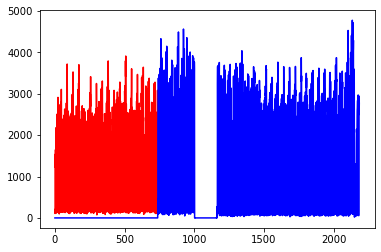

In [111]:
plt.plot(np.arange(len(pred)),pred.values,color="red")
plt.plot(np.arange(len(data1)),data1["Pedestrian"],color="b")

red is predicted values and bule is real values

In [22]:
test = train_S2.loc[train_S2["Pedestrian"]==0]
test_SS1 = train_S1[pd.to_datetime(train_S1["UTC Datetime"])>pd.to_datetime("2022-6-17")]
test_SS3 = train_S3[pd.to_datetime(train_S3["UTC Datetime"])>pd.to_datetime("2022-6-17")]
test_SS1 = test_SS1[pd.to_datetime(test_SS1["UTC Datetime"])<=pd.to_datetime("2022-7-12")]
test_SS3 = test_SS3[pd.to_datetime(test_SS3["UTC Datetime"])<=pd.to_datetime("2022-7-12")]
tests = {"S1":np.array(test_SS1["Pedestrian"]),
           "S3":np.array(test_SS3["Pedestrian"])}
tests = pd.DataFrame(tests)
new_constant=sm.add_constant(tests)
pred = result.predict(new_constant)

/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
print("6-17 to 7-12")
print(sum(pred.values))
pred2 = {"date":test["UTC Datetime"][3:],
        "Pedestrian":pred.values}
pred2 = pd.DataFrame(pred2)
pred2.head()

6-17 to 7-12
248603.99563735654


,date,Pedestrian
7152,2022-06-18,317.848569
7153,2022-06-18,161.907920
7154,2022-06-18,3421.345528
7155,2022-06-18,2666.521723
7156,2022-06-18,2826.950310


The table above shows the missing data from 6-18 to 7-12 in 2022 S2, so it is the blank at the graph

In [71]:
miss_value = footfall.loc[footfall["Pedestrian"]==0]
new_footfall =  footfall.loc[footfall["Pedestrian"]!=0]

In [25]:
from scipy.interpolate import interp1d
x = np.array(new_footfall.index)
y = np.array(new_footfall["Pedestrian"])
f = interp1d(x,y,kind="cubic")

predict_data = []
for i in miss_value.index:
    predict_data.append(f(i))

miss_value["Pedestrian"]=predict_data
miss_value.head()

/var/folders/w_/ft1536ls3k3gvb2sks5dbg8h0000gn/T/ipykernel_11431/2659616276.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  miss_value["Pedestrian"]=predict_data


,UTC Datetime,Local Datetime,countlineId,countlineName,Sensor Number,direction,Pedestrian
3570,2021-12-01,2021-12-01,22995,S2_StGeorgesUpperSt_dlr001,S2,in,1303.9885998018083
3571,2021-12-01,2021-12-01,22995,S2_StGeorgesUpperSt_dlr001,S2,out,884.2018850542585
3572,2021-12-01,2021-12-01,22994,S2_StGeorgesUpperSt_pathLHS_dlr001,S2,in,717.9358959551748
3573,2021-12-01,2021-12-01,22994,S2_StGeorgesUpperSt_pathLHS_dlr001,S2,out,684.4866727023823
3574,2021-12-01,2021-12-01,22996,S2_StGeorgesUpperSt_pathRHS_dlr001,S2,in,663.1502554937055


### What you see above is the prediciton of missing data by  1D interpolation. Because you could easily predict all missing data by interpolation at once, so what you see below is a general graph of all predicted missing data.

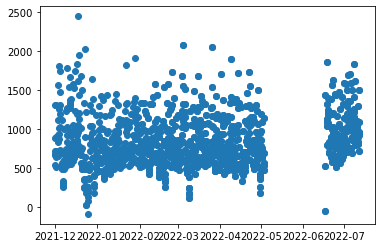

In [26]:
plt.scatter(pd.to_datetime(miss_value["UTC Datetime"]),predict_data)

In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
a = cla(footfall_2021,"S2")
data1 = a.area

ff = data1.loc[pd.to_datetime(data1["UTC Datetime"])<pd.to_datetime("2021-12-1")]
model=sm.tsa.statespace.SARIMAX(ff['Pedestrian'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
predd = results.predict(start=len(ff)+1,end=len(data1),dynamic=True)
predd

/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters f

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.21393D+00    |proj g|=  7.69049D-02

At iterate    5    f=  7.18162D+00    |proj g|=  2.45693D-03

At iterate   10    f=  7.18011D+00    |proj g|=  3.63848D-02

At iterate   15    f=  7.15247D+00    |proj g|=  1.24972D-02

At iterate   20    f=  7.13702D+00    |proj g|=  4.52591D-03

At iterate   25    f=  7.04519D+00    |proj g|=  3.36870D-02

At iterate   30    f=  7.03386D+00    |proj g|=  8.71214D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/jiang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


1189    -142.612089
1190    2075.780155
1191    2476.629222
1192    3115.814623
1193    2842.167410
           ...     
1370    2060.665616
1371    2392.363277
1372    2961.239950
1373    2684.605801
1374     317.940345
Name: predicted_mean, Length: 186, dtype: float64

### What you see above is the prediction from ARIMA for 2022 Dec, and below is a graph combined the real data(blue) from May to Nov. and predicted data(Orange) of Dec. As you see from the predicted data, there are some numbers are negative, so the accuracy of prediction may not very good.

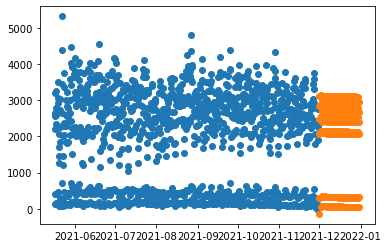

In [29]:
aa = np.array(data1.loc[pd.to_datetime(data1["UTC Datetime"])>=pd.to_datetime("2021-12-1")]["UTC Datetime"])
plt.scatter(pd.to_datetime(ff["UTC Datetime"]),ff["Pedestrian"])
plt.scatter(aa,predd)